# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [11]:
from tensorflow import keras
from keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
from keras.optimizers import Adam

In [12]:
# В качестве энкодера используем предобученную модель MobileNetV2
from keras.applications.vgg19 import VGG19
# Импортируем предобученную модель MobileNetV2, оставляя только слои, используемые для извлечения признаков
encoder_model = VGG19(include_top=False, input_shape=(224, 224, 3))

encoder_model.trainable = False

encoder_model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
autoencoder_model = Sequential()
autoencoder_model.add(encoder_model)
autoencoder_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.summary()

autoencoder_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                    

In [14]:
seed = 24
batch_size = 64

In [15]:
def prepocess_image(image):
        lab = rgb2lab(image)
        x = gray2rgb(lab[:,:,0])
        x = keras.applications.vgg19.preprocess_input(x)
        y = lab[:,:,1:] / 128
        return (x, y)

In [16]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def preprocess_data(images):
    max_workers = 20
    X = []
    Y = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for image in images:
            future = executor.submit(prepocess_image, image)
            futures.append(future)
        

        for future in as_completed(futures):
            x, y = future.result()
            X.append(x)
            Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)

    return (X, Y)

In [7]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames


In [8]:
def trainGenerator(train_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)

    for img in image_generator:
        gray, orig = preprocess_data(img)
        yield (gray, orig)


In [9]:
train_img_path = r'.\data\colorize\train'
train_img_gen = trainGenerator(train_img_path)

val_img_path = r'.\data\colorize\val'
val_img_gen = trainGenerator(val_img_path)

# test_img_path = r'.\data\colorize\test'
# test_img_gen = trainGenerator(test_img_path)


In [10]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size


Found 2048 images belonging to 1 classes.


In [11]:
filenames = get_filenames(val_img_path)
steps_per_epoch_val = len(filenames) // batch_size


Found 256 images belonging to 1 classes.


In [12]:
history = autoencoder_model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=val_img_gen
    )


Found 2048 images belonging to 1 classes.
Epoch 1/20
32/32 [==============================] - 19s 358ms/step - loss: 127.7856 - accuracy: 0.4188 - val_loss: 134.1189 - val_accuracy: 0.3941
Epoch 2/20
32/32 [==============================] - 11s 354ms/step - loss: 126.3588 - accuracy: 0.4165 - val_loss: 135.1752 - val_accuracy: 0.3984
Epoch 3/20
32/32 [==============================] - 19s 599ms/step - loss: 125.8758 - accuracy: 0.4778 - val_loss: 124.9926 - val_accuracy: 0.5319
Epoch 4/20
32/32 [==============================] - 11s 349ms/step - loss: 125.1763 - accuracy: 0.5329 - val_loss: 129.0597 - val_accuracy: 0.5419
Epoch 5/20
32/32 [==============================] - 11s 357ms/step - loss: 124.8333 - accuracy: 0.5372 - val_loss: 132.8044 - val_accuracy: 0.5339
Epoch 6/20
32/32 [==============================] - 11s 354ms/step - loss: 124.4973 - accuracy: 0.5429 - val_loss: 140.6439 - val_accuracy: 0.5399
Epoch 7/20
32/32 [==============================] - 11s 354ms/step - loss: 1

In [14]:
autoencoder_model.save('.\models\colorize_autoencoder_VGG19.h5')

In [62]:
def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (224,224), anti_aliasing=True)
    test *= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    L = keras.applications.vgg19.preprocess_input(L)
    ab = autoencoder_model.predict(L)

    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    
    rgb = cv2.cvtColor(cur.astype('uint8'), cv2.COLOR_LAB2RGB)
    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(orig.astype("uint8"))
    orig_plt.set_title("original")
    orig_plt.axis("off")

    gray_plt = plt.subplot(1, 3, 2)
    gray_plt.set_title("GRAY")
    gray_plt.axis("off")
    gray_plt.imshow(l.astype("uint8"), cmap=plt.cm.gray)

    rgb_plt = plt.subplot(1, 3, 3)
    rgb_plt.imshow(rgb.astype("uint8"))
    rgb_plt.set_title("RGB recovered")
    rgb_plt.axis("off")

1/1 [==============================] - 0s 16ms/step


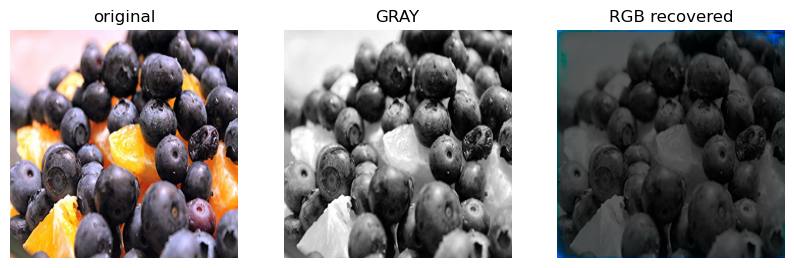

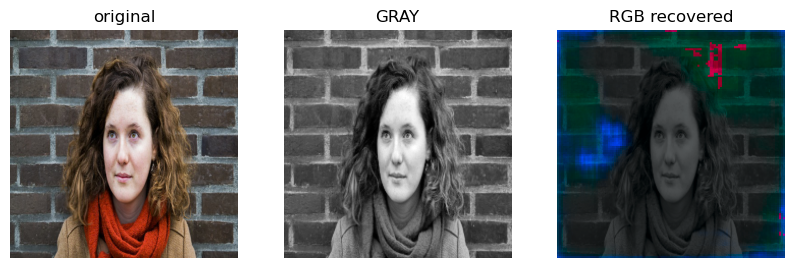

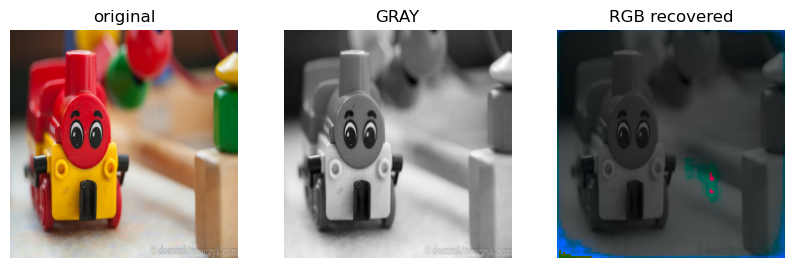

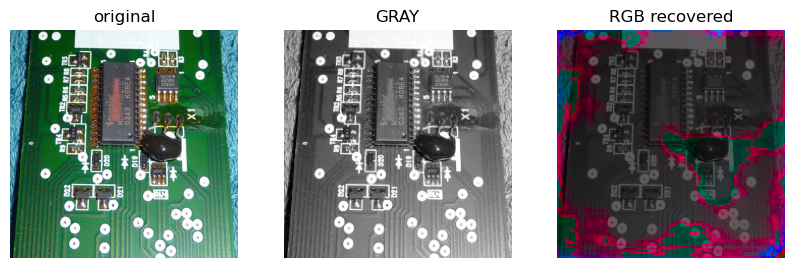

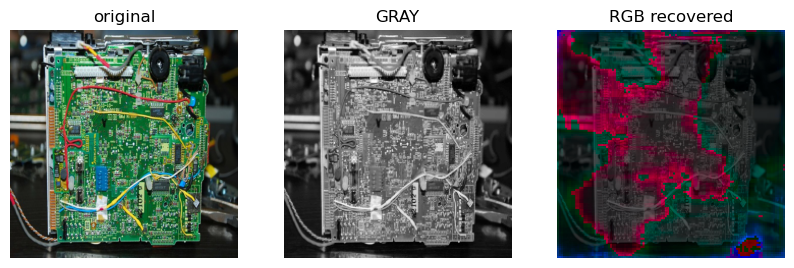

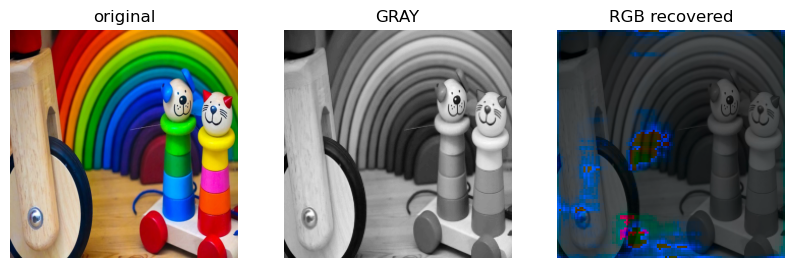

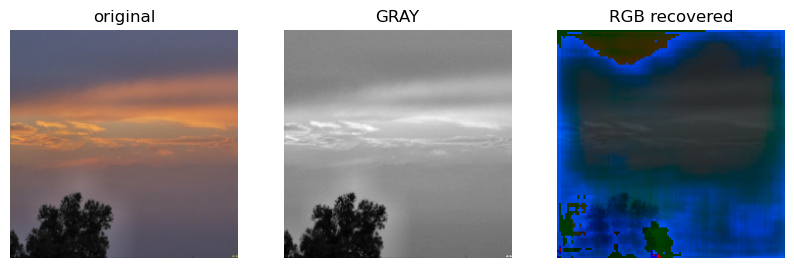

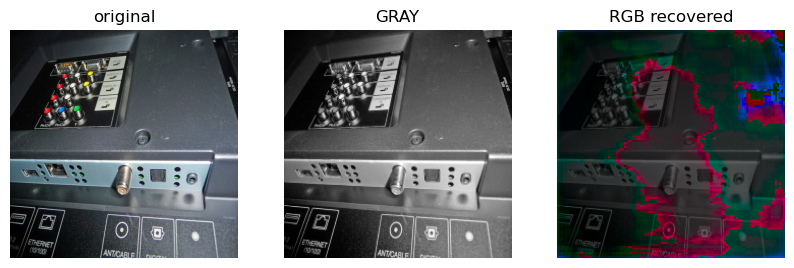

In [65]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r".\data\colorize\test\images")))
for imagePath in imagePaths:
    predict(imagePath)

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras
Датасет фото с шумом и без https://www.eecs.yorku.ca/~kamel/sidd/dataset.php

In [3]:
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator


In [4]:
input = layers.Input(shape=(224, 224, 3))

# Encoder
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 32)        18464 

In [5]:
seed = 24
batch_size = 64

In [6]:
def preprocess_data(img, watermark):
    img = img.astype("float32") / 255.0
    watermark = watermark.astype("float32") / 255.0
    img = np.reshape(img, (len(img), 224, 224, 3))
    watermark = np.reshape(watermark, (len(watermark), 224, 224, 3))
      
    return (img, watermark)

In [7]:
def trainGenerator(train_img_path, watermark_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)
    
    watermark_generator = image_datagen.flow_from_directory(
        watermark_img_path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, watermark_generator)
    
    for (img, watermark) in train_generator:
        img, watermark = preprocess_data(img, watermark)
        yield (img, watermark)

In [8]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames

In [9]:
train_img_path = r'.\data\denoise\train\gt'
watermark_img_path = r'.\data\denoise\train\watermark'
train_img_gen = trainGenerator(train_img_path, watermark_img_path)

In [10]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size

NameError: name 'ImageDataGenerator' is not defined

In [92]:
history = autoencoder.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    batch_size=batch_size,
    epochs=100,
    verbose=1,
    )

Epoch 1/100


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 563, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "c:\ProgramData\Anaconda3\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "c:\ProgramData\Anaconda3\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_13804\2762072322.py", line 1, in <module>
      history = autoencoder.fit(
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/mul'
required broadcastable shapes
	 [[{{node binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_train_function_12285]

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
# Ваш код
